# load bitstream

In [1]:
import sys
import json
import requests
import numpy as np                                                                                         
import matplotlib.pyplot as plt
import pickle

from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import Image, display

from time import sleep
from tqdm import tqdm
from attrdict import AttrDict
from datetime import date

sqclib = '/home/xilinx/jupyter_notebooks/nthu/Library'
sys.path.append(sqclib)
from sqckit.labber_toolv2 import InstrManager, hdf5_generator

qick_path = '/home/xilinx/jupyter_notebooks/nthu/Library/qick_lib'
sys.path.append(qick_path)
from qick import *


bitfile_path = '/home/xilinx/jupyter_notebooks/nthu/sinica-5q/top_216-pfb2.bit'
soc = QickSoc(bitfile = bitfile_path, external_clk = True)
port_map = {'0_230':0, '1_230':1, '2_230':2, '3_230':3,
                '0_231':4, '1_231':5, '2_231':6}
 


soccfg = soc
print(soc)

Load qick_lib to the environment.
Load sqckit to the environment.
Load labber_api to the environment.


resetting clocks: 245.76 491.52

QICK configuration:

	Board: ZCU216

	Software version: 0.2.220
	Firmware timestamp: Mon Jan 15 21:47:46 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)


# Build DAC gain to power table

## setup

  0%|          | 0/100 [00:00<?, ?it/s]

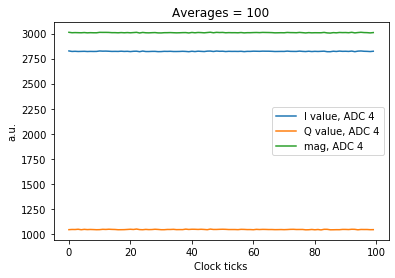

In [2]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):

        
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        
        
        
config={"res_ch":6, # --Fixed
        "ro_chs":[4], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":200, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

 
    
prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)


plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();        

In [80]:
    
prog =LoopbackProgram(soccfg, config)
avgi, avgq = prog.acquire(soc, progress=True)

np.abs(avgi[0][0] + 1j*avgq[0][0])

  0%|          | 0/100 [00:00<?, ?it/s]

3005.755154356065

## generate table

In [5]:
 
config={"res_ch":6, # --Fixed
        "ro_chs":[4], # --Fixed
        "reps":100, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":200, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }


DACGain2ADCLevel = dict()


for freq in tqdm(range(100, 1000, 5)):

    config['pulse_freq'] = freq
    DACGain2ADCLevel[freq] = dict()
  
    for gain in np.arange(10, 30000, 1000):
        
        config['pulse_gain'] = gain
        
        prog =LoopbackProgram(soccfg, config)
        avgi, avgq = prog.acquire(soc, load_pulses=True, progress=False)
      
        DACGain2ADCLevel[freq][gain] = round(float(np.abs(avgi[0][0] + 1j*avgq[0][0])), 2)
 
 
len(list(DACGain2ADCLevel.keys())), len(list(DACGain2ADCLevel[100].keys()))

  0%|          | 0/180 [00:00<?, ?it/s]

clearing streamer buffer
buffer cleared


100%|██████████| 180/180 [00:29<00:00,  6.08it/s]


(180, 30)

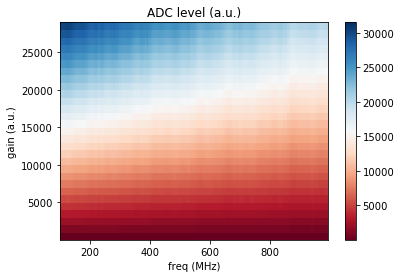

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# ADCLevel2Power = ADCtable
x, y = np.meshgrid(list(DACGain2ADCLevel.keys()), list(DACGain2ADCLevel[100].keys()))

z = np.zeros(x.shape)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = DACGain2ADCLevel[x[i, j]][y[i, j]]
        
fig, ax = plt.subplots()
ax.set_title('ADC level (a.u.)')

plt.pcolormesh(x, y, z, cmap='RdBu', vmin = np.abs(z).min(), vmax = np.abs(z).max())
plt.colorbar()


plt.xlabel("freq (MHz)")
plt.ylabel("gain (a.u.)")


plt.show()

In [10]:
import pickle# check save    
with open('ADCLevel2Power_balun-1000_top216-pfb2_adc-0.pkl', 'rb') as fp:
    ADCtbl = pickle.load(fp)

len(list(ADCtbl.keys())), len(list(ADCtbl[100].keys()))       

(180, 97)

In [29]:
from bisect import bisect, insort
def LinearInterpolation(x1, x2, y1, y2, x):
    return (y2 - y1) * ((x - x1) / (x2 - x1)) + y1


def ADCLevel2Power(freqs, adcLvls, ADCtbl):
    
    try:
        tblFreqs = list(ADCtbl.keys())
        pwrs = []

        for i in range(len(freqs)):

            freq = freqs[i]
            adcLvl = adcLvls[i]

            # find upper and lower freq.
            idx = bisect(tblFreqs, freq)
            tableFreq0 = tblFreqs[idx - 1]
            tableFreq1 = tblFreqs[idx]

            tblADCLvl0 = list(ADCtbl[tableFreq0].values())
            tblADCLvl1 = list(ADCtbl[tableFreq1].values())
            tblPwrs0 = list(ADCtbl[tableFreq0].keys())
            tblPwrs1 = list(ADCtbl[tableFreq1].keys())


            # linear interpolation.
            idx = bisect(tblADCLvl0, adcLvl) 
            p0 = LinearInterpolation(tblADCLvl0[idx-1], tblADCLvl0[idx], 
                    tblPwrs0[idx - 1], tblPwrs0[idx], adcLvl)

            # linear interpolation.
            idx = bisect(tblADCLvl1, adcLvl)
            p1 = LinearInterpolation(tblADCLvl1[idx-1], tblADCLvl1[idx], 
                    tblPwrs1[idx - 1], tblPwrs1[idx], adcLvl)

            # linear interpolation.
            p = LinearInterpolation(tableFreq0, tableFreq1, p0, p1, freq)

            pwrs.append(p)
        return pwrs
    except:
        return [None]
    


DACGain2Power = {}

for freq in list(DACGain2ADCLevel.keys()):
    
    DACGain2Power[freq] = {}
    
    for gain in list(DACGain2ADCLevel[100].keys()):
        
        freqs = [freq]
        adcLvls = [ DACGain2ADCLevel[freq][gain] ]
        
        DACGain2Power[freq][gain] = ADCLevel2Power(freqs, adcLvls, ADCtbl)[0]
        
     

## print table

In [33]:
 
gainidx_step = 2

print('     ', end='')
for gain in list(DACGain2Power[100].keys())[::gainidx_step]:
    s = str(gain)
    print(f'{s:>8}', end='')
print()

print('     ', end='')
for gain in list(DACGain2Power[100].keys())[::gainidx_step]:
    s = '________'
    print(f'{s:>8}', end='')
print()

for freq in list(DACGain2Power.keys())[::5]:
    s = str(freq) + "|"
    print(f'{s:>5}', end='')
    for gain in list(DACGain2Power[100].keys())[::gainidx_step]:
     
        s = str(round(DACGain2Power[freq][gain], 2))
        print(f'{s:>8}', end='')
    print()

           10    2010    4010    6010    8010   10010   12010   14010   16010   18010   20010   22010   24010   26010   28010
     ________________________________________________________________________________________________________________________
 100|  -50.18   -25.0  -18.98  -15.44  -12.94  -11.03   -9.42   -8.09   -6.93   -5.92   -5.01   -4.18   -3.41   -2.72   -2.08
 125|  -50.18  -24.94  -18.95  -15.43  -12.93  -11.01   -9.41   -8.08   -6.92   -5.93   -5.01   -4.18   -3.41   -2.72   -2.08
 150|  -50.18   -25.0  -19.02  -15.49  -12.99  -11.09   -9.49   -8.16   -6.99   -6.01   -5.09   -4.26   -3.49    -2.8   -2.16
 175|  -50.18  -25.04  -19.06  -15.54  -13.04  -11.12   -9.52    -8.2   -7.03   -6.03   -5.11   -4.27   -3.51   -2.81   -2.18
 200|  -50.18  -25.13  -19.14  -15.61  -13.11   -11.2    -9.6   -8.27    -7.1   -6.11    -5.2   -4.36    -3.6    -2.9   -2.27
 225|  -50.18  -25.22  -19.23   -15.7  -13.21  -11.29   -9.69   -8.36   -7.19   -6.17   -5.26   -4.43   -3.66   -2.96 

## save table

In [34]:
import pickle

with open('DACGain2Power_balun-1000_top216-dac6-adc4.pkl', 'wb') as fp:
    pickle.dump(DACGain2Power, fp)

    
# check save    
with open('DACGain2Power_balun-1000_top216-dac6-adc4.pkl', 'rb') as fp:
    dactbl = pickle.load(fp)

len(list(dactbl.keys())), len(list(dactbl[100].keys())) 

(180, 30)